# Child Mind Institute - Problematic Internet Usage

In [710]:
# -----------------------------------------
# notebook settings
# -----------------------------------------

# data location (change if not on Kaggle)
dir = "/kaggle/input/child-mind-institute-problematic-internet-use/"

# include season columns?
include_season = False # Don't change this. Better not to include

# drop rows with high missingness?
drop_high_misssing_rows = False # Don't change this. Results were worse
row_missing_thresh = 80 # rows with x% will be dropped

# drop features with high missingness?
drop_high_misssing_cols = False
col_missing_thresh = 80 # cols with x% will be dropped

# imputation?
mean_imputation = False
knn_imputation = False
n_neighbors = 5 # change setting for knn
iterative_imputation = True
# ensure only 1 imputation method is used at a time
imputation_methods = [mean_imputation, knn_imputation, iterative_imputation]
if sum(imputation_methods) > 1:
    raise ValueError("Only one imputation method can be enabled at a time.")

# feature extraction/selection
feature_extraction = True
if feature_extraction == 1 and sum(imputation_methods) != 1:
    raise ValueError("Must include imputation method to do feature extraction.")

# include prcoessed actigraphy data?
include_PA = True

# include autoencoded actigraphy data?
include_autoencoding = False # decided not to include this

# new features to indicate missingness?
indicate_missingness = False

# drop rows missing target? Set to false if you want to do semi-supervised learning
drop_missing_target = True

# semi-supervised learning? (won't drop missing target if you do this)
semisupervised_learning = ~drop_missing_target

In [711]:
# -----------------------------------------
# Install (if necessary) and load libraries
# -----------------------------------------

# !pip install optuna
# !pip install catboost

import warnings
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # Required to enable IterativeImputer
from sklearn.impute import KNNImputer, IterativeImputer
import optuna
from catboost import CatBoostRegressor, MultiTargetCustomMetric
from numpy.typing import ArrayLike, NDArray
from sklearn.base import BaseEstimator
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore", message="Failed to optimize method")

# Processing

## Actigraphy Processing
Commented out since it takes a while to run and uploaded the datasets instead. Should do a final submission with the actigraphy processing included once I decide on the final model.

In [712]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# import datetime
# from tqdm import tqdm

In [713]:
# # all participant data to loop over
# base_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'
# subdirs = os.listdir(base_dir)
# pids = [s.replace('id=', '') for s in subdirs]

In [714]:
# # functions that can be used for each participant
# def read_parquet(pid):
#     # Construct the full path to the Parquet file
#     file_path = os.path.join(base_dir, 'id='+pid, 'part-0.parquet')
    
#     # Read the Parquet file into a DataFrame
#     df = pd.read_parquet(file_path)

#     return df

# def format_time(t):
#     # Convert string to integer (assuming it's in nanoseconds)
#     nanoseconds = int(t)
    
#     # Convert nanoseconds to a timedelta object
#     time_delta = datetime.timedelta(microseconds=nanoseconds / 1000)  # Convert nanoseconds to microseconds

#     # Format the timedelta to the desired format
#     formatted_time = str(time_delta)
    
#     # Optionally, if you want to match exactly the "%H:%M:%S.%9f" format
#     hours, remainder = divmod(time_delta.seconds, 3600)
#     minutes, seconds = divmod(remainder, 60)
#     microseconds = time_delta.microseconds

#     # Format with leading zeros if necessary
#     return f"{hours:02}:{minutes:02}:{seconds:02}"

# def create_datetime_col(df):
#     base_date = pd.to_datetime('2024-11-14')  # Initialize date from a first relative date (not the real date)
#     df['date'] = df['relative_date_PCIAT'].apply(lambda x: base_date + pd.to_timedelta(x, unit='D'))
#     df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['formatted_time'])
#     df = df.drop(columns=['date'])
#     return df

# def plot_participant_activity(df):
#     dates = df['datetime'].dt.date.unique()
#     plt.figure(figsize=(10,5))
#     for i in range(len(dates)):
#         filtered_df = df[df['datetime'].dt.date == dates[i]].copy()
        
#         # Convert time to minutes since midnight
#         filtered_df['time_in_minutes'] = filtered_df['datetime'].dt.hour * 60 + filtered_df['datetime'].dt.minute
        
#         # Plot the data
#         sns.lineplot(x=filtered_df['time_in_minutes'], y=filtered_df['enmo'], alpha = 0.3, errorbar=None)
        
#         plt.xticks(rotation=90)
    
#     # format plot
#     plt.title('Participant Activity Patterns During Day')
#     plt.xlabel('Time of Day (min)')
    
#     # Show the plot
#     plt.show()


# # Should we do subsampling? We only need to do this if our computers can't handle this amount of data

# # How should we deal with idle_sleep_mode? 
# # During periods of no motion, the watch will not record any data. 
# # So we could be understating that amount of sedentary periods if we don’t account for this somehow.


# # activity levels (using enmo)
# def get_activity_levels(df, thresholds = (0.0563, 0.1916, 0.6958)):
#     """
#     Returns the percent of time spent sedentary or doing light, moderate, or vigorous activity.
#     The percent of time is dependent on the amount of data we have for each participant.

#     Args:
#         df: a single participant's enom measurements over time
#         thresholds: tuple of light, moderate, and vigorous physical activity thresholds (Hildebrand 2014)
#     """
#     light_threshold = thresholds[0]
#     moderate_threshold = thresholds[1]
#     vigorous_threshold = thresholds[2]
    
#     # Create a function to classify the activity level
#     def classify_activity(enmo_value):
#         if enmo_value <= light_threshold:
#             return 'sendentary'
#         elif enmo_value <= moderate_threshold:
#             return 'light'
#         elif enmo_value <= vigorous_threshold:
#             return 'moderate'
#         else:
#             return 'vigorous'
    
#     # Apply the function to the ENMO series
#     activity_level_series = df['enmo'].apply(classify_activity)
#     activity_level_series = activity_level_series.value_counts() / len(activity_level_series)
#     activity_level_dict = dict(activity_level_series)
#     return activity_level_dict

In [715]:
# # process train actigraphy data
# activity_level_list = []
# for pid in tqdm(pids, desc="Processing pids", unit="pid"):
#     df = read_parquet(pid)
#     df['formatted_time'] = df['time_of_day'].apply(format_time)
#     df = create_datetime_col(df)
#     activity_level_list.append(get_activity_levels(df))
# PA_data = pd.DataFrame(activity_level_list, index=pids)
# PA_data.to_csv('/kaggle/input/pa-data2/PA_data.csv')

In [716]:
# # process test actigraphy data
# base_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet'
# subdirs = os.listdir(base_dir)
# pids = [s.replace('id=', '') for s in subdirs]
# activity_level_list = []
# for pid in tqdm(pids, desc="Processing pids", unit="pid"):
#     df = read_parquet(pid)
#     df['formatted_time'] = df['time_of_day'].apply(format_time)
#     df = create_datetime_col(df)
#     activity_level_list.append(get_activity_levels(df))
# PA_data = pd.DataFrame(activity_level_list, index=pids)
# PA_data.to_csv('/kaggle/input/pa-data2/PA_data_test.csv')

## Survey Processing

In [717]:
# Load data
data_dictionary = pd.read_csv(dir + "data_dictionary.csv")
train_data = pd.read_csv(dir + "train.csv")
test_data = pd.read_csv(dir + "test.csv")

# read aggregated actigraphy
actigraphy_data = pd.read_csv('/kaggle/input/pa-data2/PA_data.csv', index_col=0)
test_actigraphy_data = pd.read_csv('/kaggle/input/pa-data2/PA_data_test.csv', index_col=0)

In [718]:
# define target columns for multiple regression
TARGET_COLS = [
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total",
    "sii",
]

### Train

In [719]:
# TRAIN
# Outliers ----------------------------------------------------------------------------
# removing outliers (should change this to be automatic so it applies to the test data)
# From CGAS
train_data.loc[2065, 'CGAS-CGAS_Score'] = 99
# From BIA (there might still be some suspicious extreme values)
cols = data_dictionary.loc[(data_dictionary['Instrument'] == 'Bio-electric Impedance Analysis') & (data_dictionary['Type'] == 'float'), 'Field']
train_data.loc[[3205, 3511], cols] = np.nan # remove 3511 and 3205's BIA values because they seem wrong. They have normal heights and weights but extreme values for BIA measures

# Drop features ----------------------------------------------------------------------
# combine FitnessGram Minutes and seconds
train_data['Fitness_Endurance-Total_Time_sec'] = train_data['Fitness_Endurance-Time_Mins'] * 60 + train_data['Fitness_Endurance-Time_Sec'] # remove remaining Fitness_Endurance Columns
# drop any column that ends in -Season, remaining Fitness_Endurance columns, and redundant SDS column
# Identify columns containing the word "season"
season_cols = [col for col in train_data.columns if "season" in col.lower() and col != 'PCIAT-Season']
if include_season:
    # Ensure these columns are treated as categorical
    train_data_cleaned = train_data.copy()
    for col in season_cols:
        train_data_cleaned[col] = train_data_cleaned[col].fillna('missing').astype('category')
    train_data_cleaned = train_data_cleaned.drop(columns='PCIAT-Season')
    cat_features = season_cols
else:
    columns_to_drop = [col for col in train_data.columns if col.endswith('Season')]
    columns_to_drop.extend(['Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins'])
    train_data_cleaned = train_data.drop(columns=columns_to_drop)
    cat_features = None

# merge PAQ_A and PAQ_C
# keep adolescent value if 13 or older
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] >= 13), 'PAQ_C-PAQ_C_Total'] = np.nan
# keep child value is younger than 13
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] < 13), 'PAQ_A-PAQ_A_Total'] = np.nan
# merge columns
train_data_cleaned['PAQ-PAQ_Total'] = train_data_cleaned['PAQ_A-PAQ_A_Total'].fillna(train_data_cleaned['PAQ_C-PAQ_C_Total'])
# drop columns
train_data_cleaned = train_data_cleaned.drop(columns = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])

In [720]:
# drop rows with high missingness (unsuccessful)
if drop_high_misssing_rows:
# Drop rows with high missingness (should investigate characteristics of rows with high missingness)
# Might not want to drop rows with high missingness because there are also rows with high missingness in the test dataset
    percent_missing_per_row = train_data_cleaned.isnull().mean(axis=1) * 100
    high_missingness_idx = percent_missing_per_row[percent_missing_per_row > row_missing_thresh].index.values
    train_data_cleaned = train_data_cleaned.drop(high_missingness_idx)
    print(f'{len(high_missingness_idx)} rows dropped because {row_missing_thresh}% or more of the data was missing.')
    print(f'There are {len(train_data_cleaned)} rows remaining in the train data.')

In [721]:
# Drop features with high missingness?
print('This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.')
display(train_data_cleaned.notna().mean().sort_values())
if drop_high_misssing_cols:
    percent_missing_per_col = train_data_cleaned.isnull().mean(axis=0) * 100
    cols_to_drop = percent_missing_per_col[percent_missing_per_col > col_missing_thresh].index.to_list()
    cols_to_drop = [col for col in cols_to_drop if col not in TARGET_COLS] # make sure none of the target cols are dropped
    train_data_cleaned = train_data_cleaned.drop(high_missingness_idx)
    print(f'Dropped {len(cols_to_drop)} columns because {col_missing_thresh}% or more of the data was missing.')

This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.


Fitness_Endurance-Total_Time_sec          0.186616
Fitness_Endurance-Max_Stage               0.187626
Physical-Waist_Circumference              0.226768
FGC-FGC_GSND_Zone                         0.268182
FGC-FGC_GSD_Zone                          0.268434
                                            ...   
Physical-Weight                           0.776768
PreInt_EduHx-computerinternet_hoursday    0.833586
Basic_Demos-Sex                           1.000000
Basic_Demos-Age                           1.000000
id                                        1.000000
Length: 69, dtype: float64

In [722]:
# Impute/interpolate remaining missing values using one the methods below (not necessary for CATBoost)
# only have numeric columns now, so don't need to account for that
# select columns for imputation
cols_not_for_imputation = TARGET_COLS + ['id'] + season_cols
cols_not_for_imputation = [col for col in cols_not_for_imputation if col in train_data_cleaned.columns.to_list()]
cols_for_imputation = train_data_cleaned.drop(columns=cols_not_for_imputation).columns
if mean_imputation:
    print("Starting mean imputation for missing values...")
    train_data_cleaned[cols_for_imputation] = train_data_cleaned[cols_for_imputation].apply(lambda col: col.fillna(col.mean()))
    print('Mean imputation complete.')

elif knn_imputation:
    print("Starting KNN Imputation for missing values...")
    # Initialize KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance', metric='nan_euclidean') # nan_euclidean appropriately handles missing values
    # Apply KNN imputation
    train_data_cleaned[cols_for_imputation] = imputer.fit_transform(train_data_cleaned[cols_for_imputation])
    print("KNN Imputation complete.")

elif iterative_imputation:
    print("Starting Iterative Imputation for missing values...")
    # Initialize KNNImputer
    imputer = IterativeImputer(max_iter=10, random_state=42,tol=1e-3)
    # Apply KNN imputation
    train_data_cleaned[cols_for_imputation] = imputer.fit_transform(train_data_cleaned[cols_for_imputation])
    print("Iterative Imputation complete.")

Starting Iterative Imputation for missing values...
Iterative Imputation complete.


Performing feature extraction on 42 features related to physical activity/fitness, and sleep.


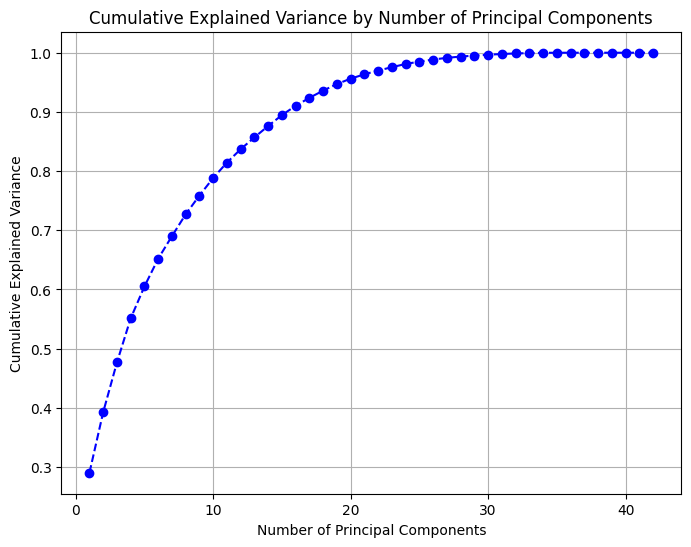

Number of components explaining at least 90% of the variance: 16
Explained variance ratio for the selected components: [0.29046649 0.10242769 0.08395662 0.07444321 0.05386391 0.04690633
 0.0381004  0.0368916  0.03169639 0.02961659 0.0260918  0.02257742
 0.01999552 0.01921585 0.01837261 0.01573245]


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


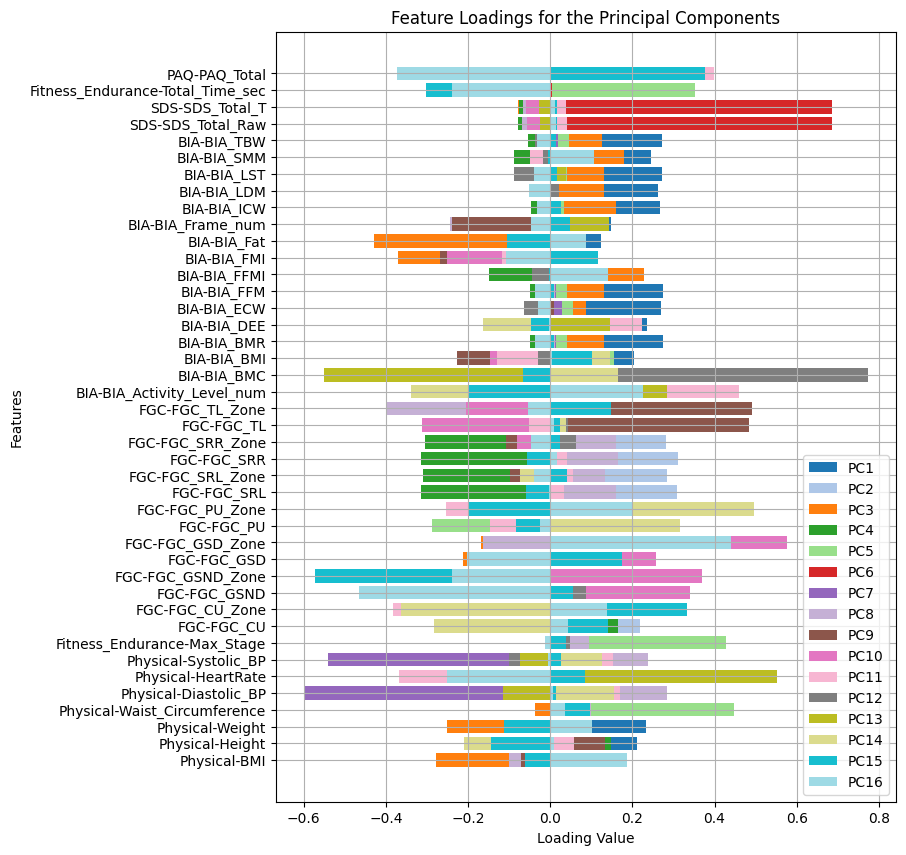

In [723]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feature_extraction_cols = train_data_cleaned.drop(columns=TARGET_COLS + ['id','Basic_Demos-Sex', 'Basic_Demos-Age', 'CGAS-CGAS_Score', 'PreInt_EduHx-computerinternet_hoursday']).columns 

if feature_extraction:
    print(f'Performing feature extraction on {len(feature_extraction_cols)} features related to physical activity/fitness, and sleep.')
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(train_data_cleaned[feature_extraction_cols])

    # Apply PCA with the number of components equal to the number of features
    pca = PCA()
    pca.fit(data_scaled)

    # Cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.title('Cumulative Explained Variance by Number of Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Determine how many components explain at least 90% variance
    num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
    print(f"Number of components explaining at least 90% of the variance: {num_components_90}")

    # Apply PCA with the optimal number of components (based on cumulative variance)
    pca = PCA(n_components=num_components_90)
    data_pca = pca.fit_transform(data_scaled)

    # Explained variance ratio of the chosen components
    print("Explained variance ratio for the selected components:", pca.explained_variance_ratio_)

    # Plot loadings for the selected components
    loadings = pca.components_

    # Create a list of feature names
    feature_names = feature_extraction_cols

    # Create a colormap with sufficient colors
    cmap = cm.get_cmap('tab20', num_components_90)  # Replace 'tab20' with any other colormap if preferred
    
    # Loop through components and plot each with a unique color
    plt.figure(figsize=(8, 10))
    for i in range(num_components_90):
        color = cmap(i)  # Get a unique color for each component
        plt.barh(range(len(loadings[i])), loadings[i], label=f'PC{i+1}', color=color)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('Feature Loadings for the Principal Components')
    plt.xlabel('Loading Value')
    plt.ylabel('Features')
    plt.legend()
    plt.grid(True)
    plt.show()

    PCA_col_names = [f'PCA{i+1}' for i in range(num_components_90)]
    PCA_df = pd.DataFrame(data_pca, columns=PCA_col_names)
    train_data_cleaned = pd.concat([train_data_cleaned[TARGET_COLS +['id','Basic_Demos-Sex', 'Basic_Demos-Age', 'CGAS-CGAS_Score', 'PreInt_EduHx-computerinternet_hoursday']], PCA_df], axis=1)

In [675]:
# include aggregate actigraphy features
if include_PA:
    train_data_cleaned = pd.merge(train_data_cleaned, actigraphy_data, left_on='id', how='left', right_index=True)

In [676]:
# include autoencoded data
if include_autoencoding:
    pass

In [677]:
# indicate missingness
if indicate_missingness:
    # Create missingness indicator columns
    missing_indicator_df = train_data_cleaned.drop(columns=TARGET_COLS + ['id']).isna().astype(int)
    
    # Concatenate the indicator columns with the original DataFrame (optional)
    train_data_cleaned = pd.concat([train_data_cleaned, missing_indicator_df.add_suffix('_missing')], axis=1)
    
    # Display the result
    display(train_data_cleaned.head(3))

In [678]:
# drop rows without target
if drop_missing_target:
    train_data_cleaned = train_data_cleaned.dropna(subset=TARGET_COLS)

In [681]:
print(f'Final length of the training dataset: {len(train_data_cleaned)}')
print(f'Final number of features (exluding targets): {len(train_data_cleaned.drop(columns=TARGET_COLS).columns)}')

Final length of the training dataset: 2671
Final number of features (exluding targets): 25


### Test

In [682]:
# Drop features ----------------------------------------------------------------------
# combine FitnessGram Minutes and seconds
test_data['Fitness_Endurance-Total_Time_sec'] = test_data['Fitness_Endurance-Time_Mins'] * 60 + test_data['Fitness_Endurance-Time_Sec'] # remove remaining Fitness_Endurance Columns
# drop any column that ends in -Season, FitnessGram Zones, remaining Fitness_Endurance columns, and redundant SDS column
if include_season:
    # Identify columns containing the word "season"
    season_cols = [col for col in test_data.columns if "season" in col.lower()]
    # Ensure these columns are treated as categorical
    test_data_cleaned = test_data.copy()
    for col in season_cols:
        test_data_cleaned[col] = test_data_cleaned[col].fillna('missing').astype("category")
else:
    columns_to_drop = [col for col in test_data.columns if col.endswith('Season')]
    columns_to_drop.extend(['Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins'])
    test_data_cleaned = test_data.drop(columns=columns_to_drop)

# columns_to_drop = [col for col in test_data.columns if col.endswith('Season')]
# columns_to_drop.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins', 'SDS-SDS_Total_Raw'])
# test_data_cleaned = test_data.drop(columns=columns_to_drop)

# merge PAQ_A and PAQ_C
# keep adolescent value if 13 or older
test_data_cleaned.loc[test_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & test_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (test_data_cleaned['Basic_Demos-Age'] >= 13), 'PAQ_C-PAQ_C_Total'] = np.nan
# keep child value if younger than 13
test_data_cleaned.loc[test_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & test_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (test_data_cleaned['Basic_Demos-Age'] < 13), 'PAQ_A-PAQ_A_Total'] = np.nan
# merge columns
test_data_cleaned['PAQ-PAQ_Total'] = test_data_cleaned['PAQ_A-PAQ_A_Total'].fillna(test_data_cleaned['PAQ_C-PAQ_C_Total'])
# drop columns
test_data_cleaned = test_data_cleaned.drop(columns = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])

In [683]:
# can't drop these rows in the test set
percent_missing_per_row = test_data_cleaned.isnull().mean(axis=1) * 100
print('This is the percent missing per row. Some participants only have a few records.')
display(percent_missing_per_row)

This is the percent missing per row. Some participants only have a few records.


0     27.659574
1     14.893617
2     36.170213
3     10.638298
4     91.489362
5      6.382979
6     17.021277
7     10.638298
8     91.489362
9     93.617021
10    93.617021
11    82.978723
12     8.510638
13    46.808511
14    91.489362
15    46.808511
16    51.063830
17    59.574468
18    14.893617
19    91.489362
dtype: float64

In [684]:
# Drop features with high missingness? Has to match features dropped for training data
print('\nThis is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.')
display(test_data_cleaned.notna().mean().sort_values())


This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.


Fitness_Endurance-Total_Time_sec          0.15
Fitness_Endurance-Max_Stage               0.15
FGC-FGC_GSND                              0.25
Physical-Waist_Circumference              0.25
FGC-FGC_GSD_Zone                          0.25
FGC-FGC_GSD                               0.25
FGC-FGC_GSND_Zone                         0.25
BIA-BIA_BMC                               0.40
BIA-BIA_Activity_Level_num                0.40
BIA-BIA_DEE                               0.40
BIA-BIA_ECW                               0.40
BIA-BIA_FFM                               0.40
BIA-BIA_FFMI                              0.40
BIA-BIA_FMI                               0.40
BIA-BIA_Fat                               0.40
BIA-BIA_Frame_num                         0.40
BIA-BIA_BMR                               0.40
BIA-BIA_ICW                               0.40
BIA-BIA_LDM                               0.40
BIA-BIA_LST                               0.40
BIA-BIA_SMM                               0.40
BIA-BIA_TBW  

In [685]:
# Impute/interpolate remeaining missing values (not necessary for CATBoost)
if mean_imputation:
    print("Starting mean imputation for missing values...")
    # Apply mean imputation to test dataset using train column means
    test_data_cleaned[cols_for_imputation] = test_data_cleaned[cols_for_imputation].apply(lambda col: col.fillna(train_data_cleaned[col.name].mean()))
    print("Mean Imputation complete.")

elif knn_imputation:
    print("Starting KNN Imputation for missing values...")
    # Use the same imputer used on the train data
    test_data_cleaned[cols_for_imputation] = imputer.transform(test_data_cleaned[cols_for_imputation])
    print("KNN Imputation complete.")

elif iterative_imputation:
    print("Starting Iterative Imputation for missing values...")
    # Use the same imputer used on the train data
    test_data_cleaned[cols_for_imputation] = imputer.transform(test_data_cleaned[cols_for_imputation])
    print("Iterative Imputation complete.")


Starting Iterative Imputation for missing values...
Iterative Imputation complete.


In [686]:
# perform the same PCA as above (using the same scaler and PCA)
if feature_extraction:
    data_scaled = scaler.transform(test_data_cleaned[feature_extraction_cols])
    data_pca = pca.transform(data_scaled)
    PCA_df = pd.DataFrame(data_pca, columns=PCA_col_names)
    test_data_cleaned = pd.concat([test_data_cleaned[['id','Basic_Demos-Sex', 'Basic_Demos-Age', 'CGAS-CGAS_Score', 'PreInt_EduHx-computerinternet_hoursday']], PCA_df], axis=1)

In [687]:
# include aggregate actigraphy features
if include_PA:
    test_data_cleaned = pd.merge(test_data_cleaned, test_actigraphy_data, left_on='id', how='left', right_index=True)

In [688]:
# include autoencoded data
if include_autoencoding:
    pass

In [689]:
if indicate_missingness:
    # Create missingness indicator columns
    missing_indicator_df = test_data_cleaned.drop(columns=['id']).isna().astype(int)
    
    # Concatenate the indicator columns with the original DataFrame (optional)
    test_data_cleaned = pd.concat([test_data_cleaned, missing_indicator_df.add_suffix('_missing')], axis=1)
    
    # Display the result
    display(test_data_cleaned.head(3))

In [690]:
# Convert categorical columns to the correct data type? Since they're ordinal, probably don't have to convert
# use data dictionary to convert features that have type=="categorical int" into str dtype
# only do this if you also do it on the train

In [691]:
print(f'Final length of the test dataset: {len(test_data_cleaned)}')

Final length of the test dataset: 20


## Final Datasets

In [692]:
# select X and y
X = train_data_cleaned.drop(columns = TARGET_COLS + ['id']).reset_index(drop=True)
X_test = test_data_cleaned.drop(columns = ['id']).reset_index(drop=True)

# check that train and test have matching columns
print(f'Same column in train and test: {pd.Series(X.columns).isin(X_test.columns).sum() == X.shape[1]}')

# train target
y = train_data_cleaned[TARGET_COLS].reset_index(drop=True)
y_sii = y["sii"].to_numpy() # ground truth

Same column in train and test: True


In [693]:
# which train columns, if any, aren't in the test set
cols = X.columns
cols[~pd.Series(X.columns).isin(X_test.columns)]

Index([], dtype='object')

# Modeling

In [694]:
class MultiTargetQWK(MultiTargetCustomMetric):
    #Custom evaluation during model training for tasks with ordered or multi-target outputs
    def get_final_error(self, error, weight):
        return np.sum(error)  # / np.sum(weight)

    def is_max_optimal(self):
        # if True, the bigger the better
        return True

    def evaluate(self, approxes, targets, weight):
        approx = np.clip(approxes[-1], 0, 3).round().astype(int)
        target = targets[-1]

        qwk = cohen_kappa_score(target, approx, weights="quadratic")

        return qwk, 1

    def get_custom_metric_name(self):
        return "MultiTargetQWK"


class OptimizedRounder:
  #Improves classification accuracy by learning optimal decision thresholds for rounding continuous model outputs into discrete classes
    def __init__(self, n_classes: int, n_trials: int = 100):
        self.n_classes = n_classes
        self.labels = np.arange(n_classes)
        self.n_trials = n_trials
        self.metric = partial(cohen_kappa_score, weights="quadratic")

    def fit(self, y_pred: NDArray[np.float_], y_true: NDArray[np.int_]) -> None:
        y_pred = self._normalize(y_pred)

        def objective(trial: optuna.Trial) -> float:
            thresholds = []
            for i in range(self.n_classes - 1):
                low = max(thresholds) if i > 0 else min(self.labels)
                high = max(self.labels)
                th = trial.suggest_float(f"threshold_{i}", low, high)
                thresholds.append(th)
            try:
                y_pred_rounded = np.digitize(y_pred, thresholds)
            except ValueError:
                return -100
            return self.metric(y_true, y_pred_rounded)

        optuna.logging.disable_default_handler()
        study = optuna.create_study(direction="maximize")
        study.optimize(
            objective,
            n_trials=self.n_trials,
        )
        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
        assert hasattr(self, "thresholds"), "fit() must be called before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: NDArray[np.float_]) -> NDArray[np.float_]:
        # normalize y_pred to [0, n_classes - 1]
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)

In [695]:
# setting catboost parameters
params = dict(
    loss_function="MultiRMSE",
    eval_metric=MultiTargetQWK(),
    iterations= 5, #1 if IS_TEST else 100000,
    learning_rate=0.1,
    depth=5,
    early_stopping_rounds=50,
    random_state = 2
)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)
models: list[CatBoostRegressor] = []
y_pred = np.full((X.shape[0], len(TARGET_COLS)), fill_value=np.nan)
for train_idx, val_idx in skf.split(X, y_sii):
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    y_train: pd.DataFrame
    y_val: pd.DataFrame
    X_train, X_val = X.loc[train_idx], X.loc[val_idx]
    y_train, y_val = y.loc[train_idx], y.loc[val_idx]

    # train model
    model = CatBoostRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        verbose=False,
    )
    models.append(model)

    # predict
    y_pred[val_idx] = model.predict(X_val)

assert np.isnan(y_pred).sum() == 0
# Optimize thresholds
optimizer = OptimizedRounder(n_classes=4, n_trials=300)
y_pred_total = y_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
optimizer.fit(y_pred_total, y_sii)
y_pred_rounded = optimizer.predict(y_pred_total)

# best thresholds
print(f'Best thresholds: {optimizer.thresholds}')

# Calculate QWK
qwk = cohen_kappa_score(y_sii, y_pred_rounded, weights="quadratic")
print(f"Cross-Validated QWK Score: {qwk}")

invalid value encountered in subtract


Best thresholds: [1.4081742715023151, 2.2619688978064825, 2.7824660211969094]
Cross-Validated QWK Score: 0.44877958488758585


In [696]:
# fit on whole dataset, and then use best thresholds
model = CatBoostRegressor(**params)
model.fit(
    X,
    y,
    cat_features=cat_features,
    verbose=False,
)
y_pred = model.predict(X)
y_pred_total = y_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
y_pred_total = (y_pred_total - y_pred_total.min()) / (y_pred_total.max() - y_pred_total.min()) * (4 - 1)
y_pred_rounded = np.digitize(y_pred_total, optimizer.thresholds)
print(y_pred_rounded)
qwk = cohen_kappa_score(y_sii, y_pred_rounded, weights="quadratic")
print(f"Train QWK Score: {qwk}")

[0 0 1 ... 1 1 2]
Train QWK Score: 0.4634389584258729


(2671, 22, 25)


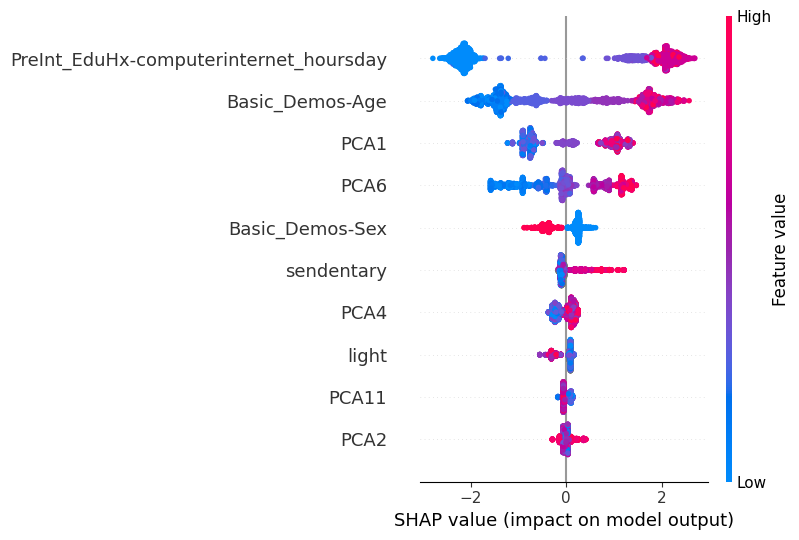

In [697]:
# this code might not be right
# double check what's going on with the dimensions of the shap output
from catboost import Pool
import shap
shap_values = model.get_feature_importance(
    Pool(X,y, cat_features=cat_features), # # include if you have any categorical features
    type='ShapValues') # shape is (obsevations, targets + 1, features + 1) last target is expected value and last feature is constant
print(shap_values.shape)

# Extract expected value and separate SHAP values
expected_values = shap_values[:, -1, :]  # Expected values for each target
shap_values = shap_values[:, :-1, :]     # Remove the expected value column

# Select target index
target_idx = TARGET_COLS.index("PCIAT-PCIAT_Total")
shap_values_target = shap_values[:, target_idx, :]

# Plot SHAP summary
shap.summary_plot(shap_values_target[:,:-1], X, max_display=10); # have to remove intercept

# Optional: Plot force plot for the first instance
# instance_idx = 0
# shap.force_plot(
#     expected_values[target_idx], 
#     shap_values_target[instance_idx, :-1], 
#     X.to_pandas().iloc[instance_idx, :-1]
# )


Text(0.5, 1.0, 'Feature Importance')

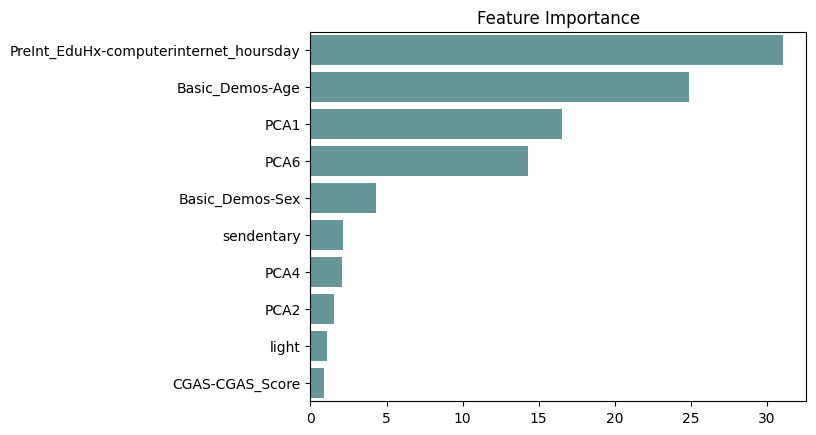

In [698]:
# feature importance based on whole training dataset
import seaborn as sns
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
# fig = plt.figure(figsize=(12, 15))
feature_importance_s = pd.Series(feature_importance[sorted_idx], index=np.array(X_test.columns)[sorted_idx])
feature_importance_s = feature_importance_s.sort_values(ascending=False).head(10)
sns.barplot(x=feature_importance_s, y=feature_importance_s.index, color='#5F9EA0')
# plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
# plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title("Feature Importance")

Confusion Matrix:
[[1104  335  116   13]
 [ 257  279  159   16]
 [  66  123  138   32]
 [   1    5   17   10]]


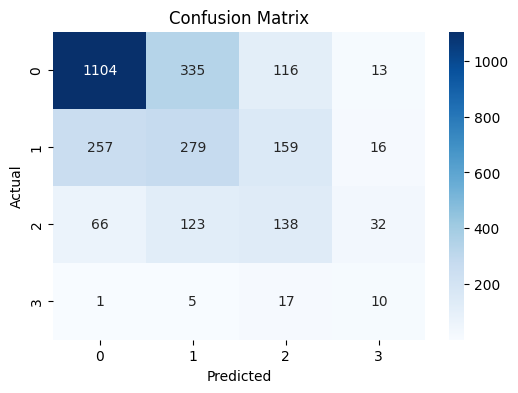

Accuracy: 0.5731935604642456
Precision: 0.598817222275611
Recall: 0.5731935604642456
F1 Score: 0.584262139984375


In [699]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_sii, y_pred_rounded)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix using heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", '2', '3'], yticklabels=["0", "1", '2', '3'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# other metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_sii, y_pred_rounded)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_sii, y_pred_rounded, average='weighted') # not sure what the setting should be
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_sii, y_pred_rounded, average='weighted')
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_sii, y_pred_rounded, average='weighted')
print(f"F1 Score: {f1}")


In [700]:
# # predict based on model fit on whole dataset
# y_test_pred = model.predict(X_test)
# y_test_pred_total = y_test_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
# y_test_pred_total = (y_test_pred_total - y_test_pred_total.min()) / (y_test_pred_total.max() - y_test_pred_total.min()) * (4 - 1)
# y_test_pred_rounded = np.digitize(y_test_pred_total, optimizer.thresholds)
# print(y_test_pred_rounded)

# # Create a DataFrame for submission
# submission_df = pd.DataFrame({
#     "id": test_data_cleaned["id"],  # Assuming your test set has an "ID" column
#     "sii": y_test_pred_rounded
# })

# # Export to CSV
# submission_df.to_csv("submission.csv", index=False)

# print("Submission file created successfully!")
# display(submission_df)

In [701]:
# Testing average predictions instead of full model predictions
# Predict on test set
y_test_pred = np.zeros((X_test.shape[0], len(TARGET_COLS)))

for model in models:
    y_test_pred += model.predict(X_test)

# Average the predictions from all models
y_test_pred /= len(models)

# Round predictions using the optimized thresholds
y_test_pred_total = y_test_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
y_test_pred_rounded = optimizer.predict(y_test_pred_total)

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    "id": test_data_cleaned["id"],  # Assuming your test set has an "ID" column
    "sii": y_test_pred_rounded
})

# Export to CSV
submission_df.to_csv("submission.csv", index=False)

print("Submission file created successfully!")
display(submission_df)

Submission file created successfully!


,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,3
5,001f3379,1
6,0038ba98,1
7,0068a485,1
8,0069fbed,3
9,0083e397,3
